
Import Modules

In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

2024-07-07 17:49:39.611074: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-07 17:49:39.611178: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-07 17:49:39.748384: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Now we must set the directories to use the data

In [2]:
BASE_DIR = '/kaggle/input/flickr-8k-dataset'
WORKING_DIR = '/kaggle/working'

Extract Image Features

We have to load and restructure the model

In [3]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


Now we extract the image features and load the data for preprocess

In [5]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

I0000 00:00:1720374634.327857  132429 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [6]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [7]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

Load the Captions Data

Let us store the captions data from the text file

In [8]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

Now we split and append the captions data with the image

In [9]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

Now let us see the no. of images loaded

In [10]:
len(mapping)

8091

Preprocess Text Data

In [11]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

Let us visualize the text before and after cleaning

In [13]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [14]:
# preprocess the text
clean(mapping)

In [15]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']


Next we will store the preprocessed captions into a list

In [16]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [17]:
len(all_captions)len(all_captions)

40455


Let us see the first ten captions

In [18]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

Now we start processing the text data

In [19]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [20]:
vocab_size

8485

In [21]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

Train Test Split

After preprocessing the data now we will train, test and split

In [22]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

Now we will define a batch and include the padding sequence

In [23]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

Model Creation

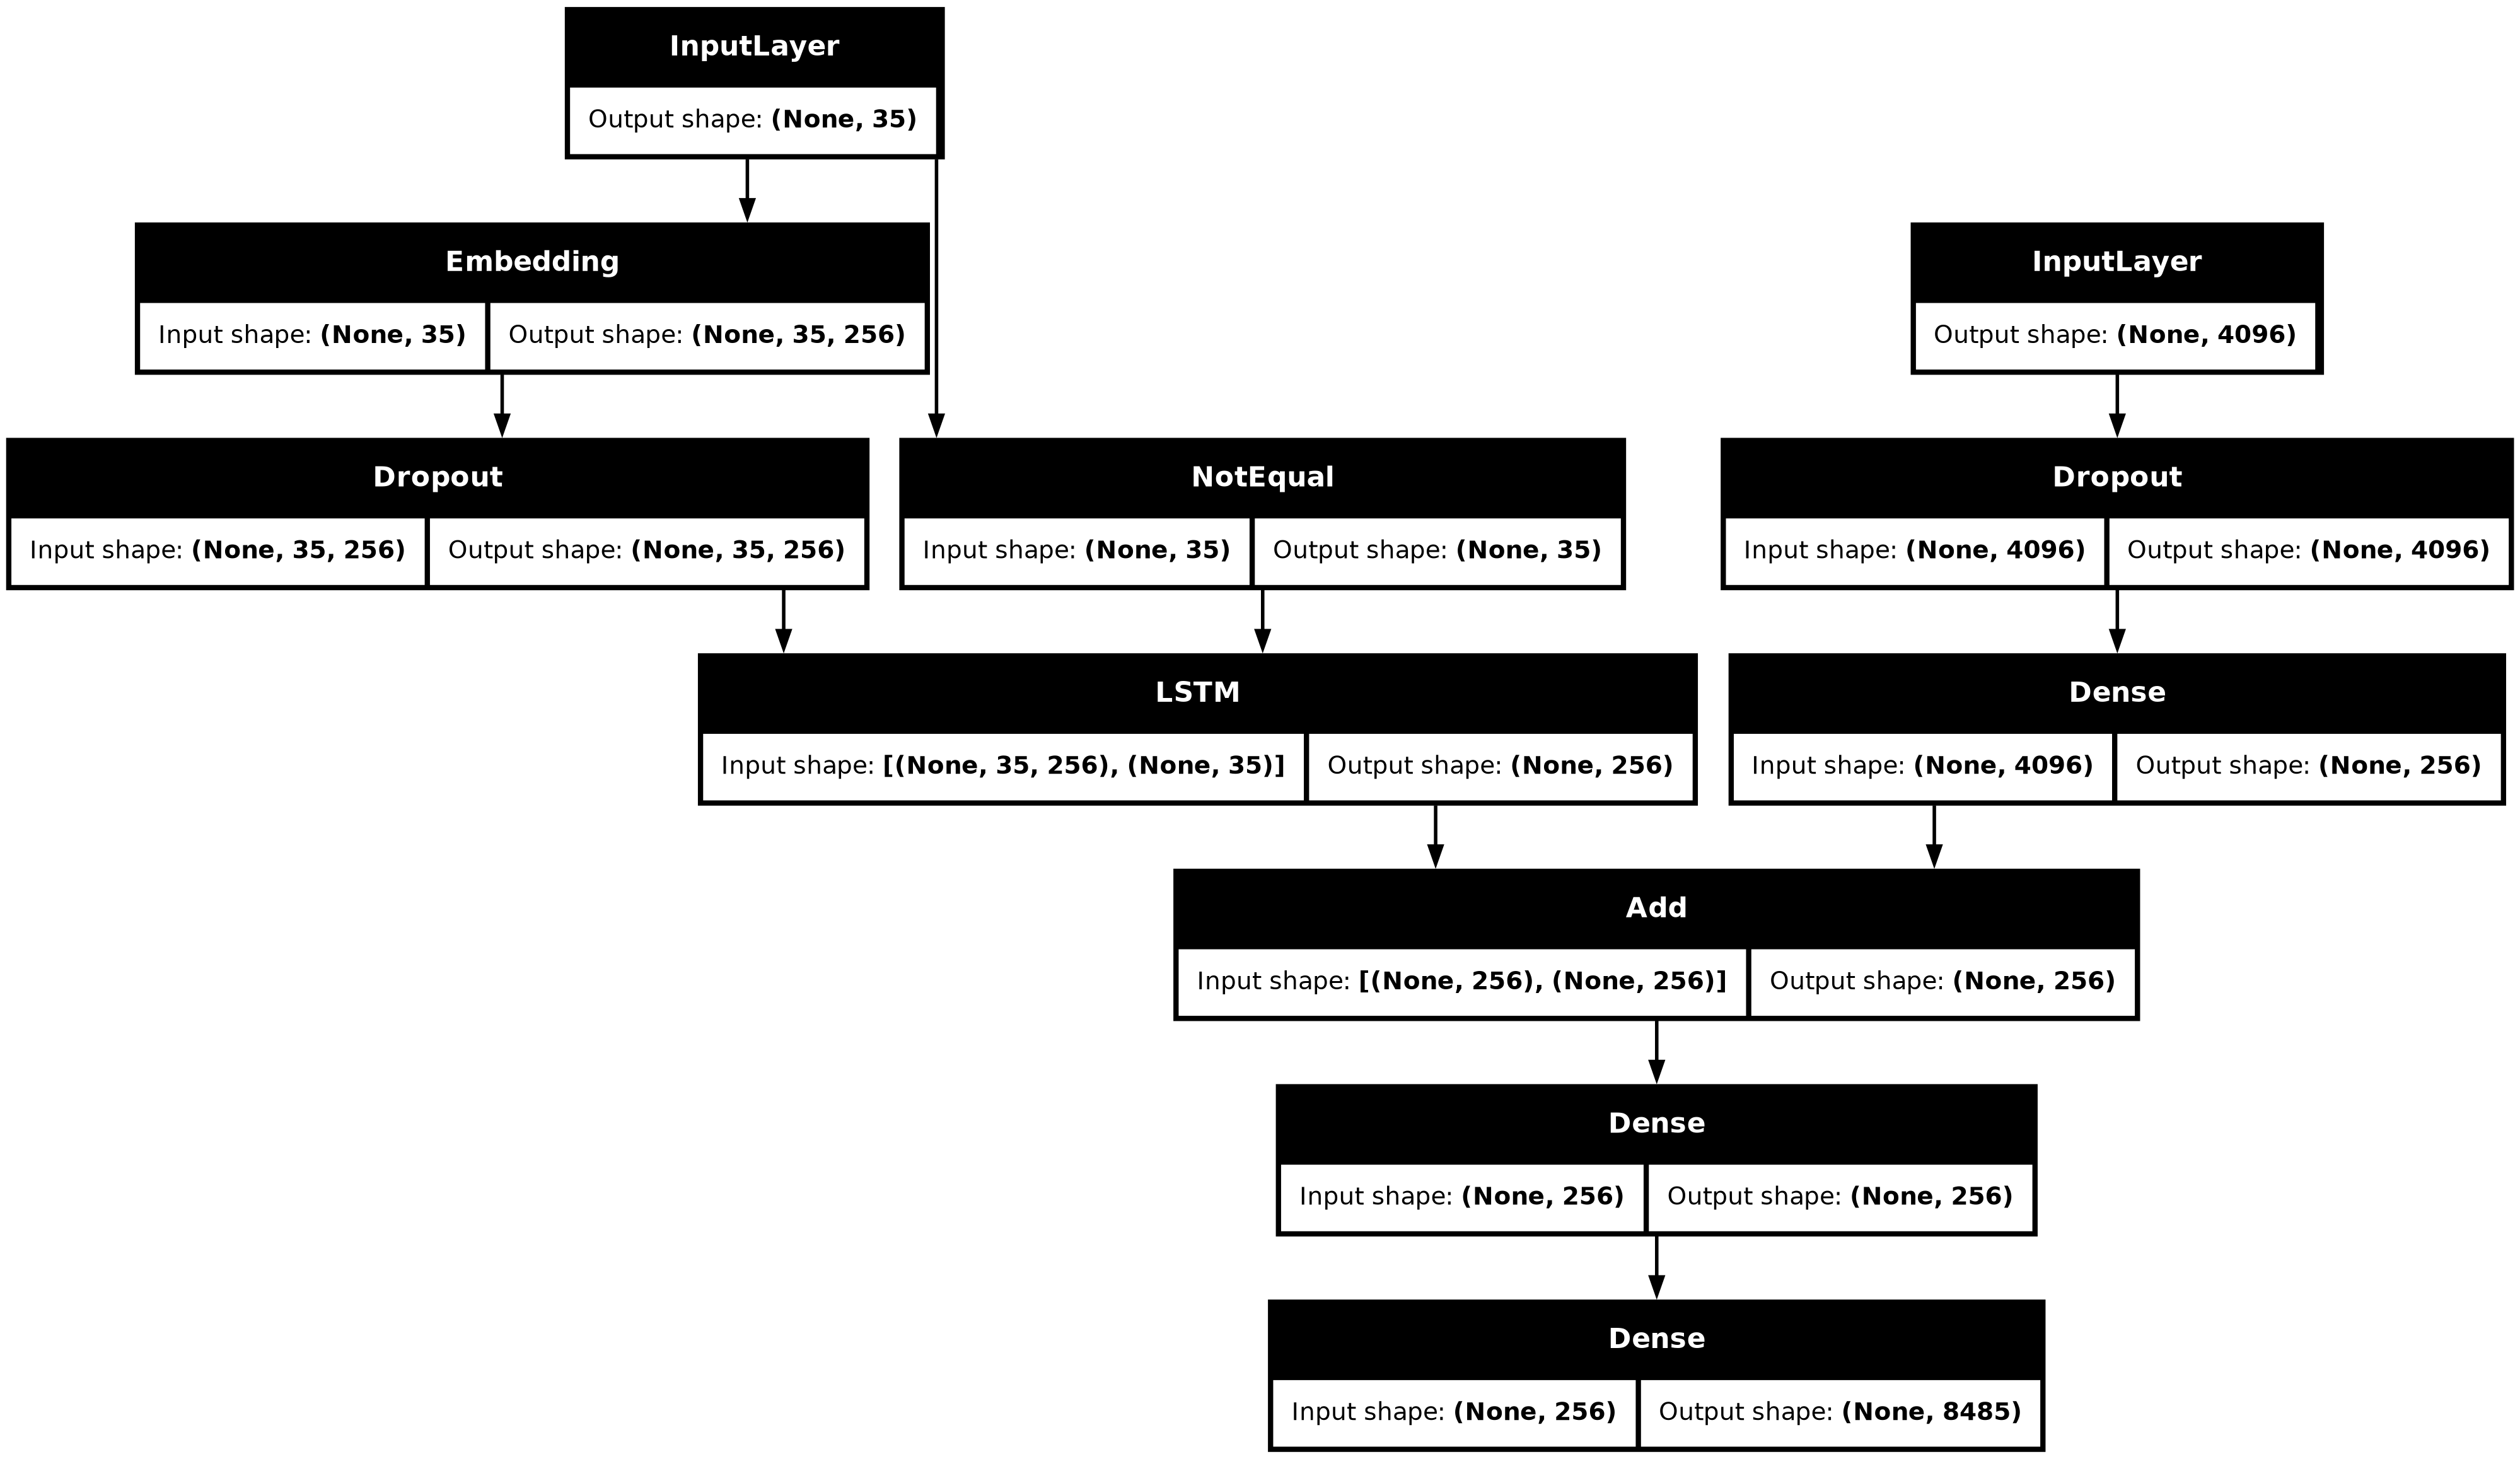

In [24]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
# Disable cuDNN for LSTM
se3 = LSTM(256, use_cudnn=False)(se2)


# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

Now let us train the model

In [25]:
# train the model
epochs = 30
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

  1/227 ━━━━━━━━━━━━━━━━━━━━ 27:17 7s/step - loss: 9.1408

W0000 00:00:1720375465.202386  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375465.258397  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375465.324006  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  2/227 ━━━━━━━━━━━━━━━━━━━━ 16:43 4s/step - loss: 9.0339

W0000 00:00:1720375469.667089  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375469.722195  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375469.783484  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  3/227 ━━━━━━━━━━━━━━━━━━━━ 16:50 5s/step - loss: 8.8950

W0000 00:00:1720375474.240255  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375474.289879  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375474.348376  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  4/227 ━━━━━━━━━━━━━━━━━━━━ 16:50 5s/step - loss: 8.7145

W0000 00:00:1720375478.793420  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375478.796604  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375478.849503  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375478.912290  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  5/227 ━━━━━━━━━━━━━━━━━━━━ 16:43 5s/step - loss: 8.5527

W0000 00:00:1720375483.274543  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375483.329785  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375483.399709  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  7/227 ━━━━━━━━━━━━━━━━━━━━ 14:02 4s/step - loss: 8.2722

W0000 00:00:1720375488.177362  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375488.233472  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375488.297800  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  8/227 ━━━━━━━━━━━━━━━━━━━━ 14:24 4s/step - loss: 8.1539

W0000 00:00:1720375492.839092  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375492.842398  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375492.895009  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375492.968923  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  9/227 ━━━━━━━━━━━━━━━━━━━━ 14:36 4s/step - loss: 8.0499

W0000 00:00:1720375497.388259  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375497.444182  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375497.506874  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 10/227 ━━━━━━━━━━━━━━━━━━━━ 14:51 4s/step - loss: 7.9576

W0000 00:00:1720375502.188747  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375502.245143  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375502.310269  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 11/227 ━━━━━━━━━━━━━━━━━━━━ 14:55 4s/step - loss: 7.8734

W0000 00:00:1720375506.644848  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375506.647912  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375506.699884  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375506.771313  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 12/227 ━━━━━━━━━━━━━━━━━━━━ 15:04 4s/step - loss: 7.7974

W0000 00:00:1720375511.503779  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375511.559396  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375511.624334  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 13/227 ━━━━━━━━━━━━━━━━━━━━ 15:06 4s/step - loss: 7.7286

W0000 00:00:1720375516.051869  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375516.107758  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375516.170287  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 14/227 ━━━━━━━━━━━━━━━━━━━━ 15:07 4s/step - loss: 7.6664

W0000 00:00:1720375520.588463  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375520.643974  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375520.707852  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 15/227 ━━━━━━━━━━━━━━━━━━━━ 15:06 4s/step - loss: 7.6089

W0000 00:00:1720375525.105258  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375525.154803  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375525.212785  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 16/227 ━━━━━━━━━━━━━━━━━━━━ 15:07 4s/step - loss: 7.5563

W0000 00:00:1720375529.735686  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375529.738666  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375529.790549  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375529.852237  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 17/227 ━━━━━━━━━━━━━━━━━━━━ 15:08 4s/step - loss: 7.5075

W0000 00:00:1720375534.438315  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375534.441708  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375534.493516  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375534.556720  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 18/227 ━━━━━━━━━━━━━━━━━━━━ 15:08 4s/step - loss: 7.4611

W0000 00:00:1720375539.131805  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375539.185986  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375539.249918  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 19/227 ━━━━━━━━━━━━━━━━━━━━ 15:10 4s/step - loss: 7.4180

W0000 00:00:1720375543.976207  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375544.031906  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375544.093500  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 20/227 ━━━━━━━━━━━━━━━━━━━━ 15:08 4s/step - loss: 7.3778

W0000 00:00:1720375548.591868  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375548.641430  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375548.700115  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 21/227 ━━━━━━━━━━━━━━━━━━━━ 15:07 4s/step - loss: 7.3398

W0000 00:00:1720375553.282053  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375553.336596  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375553.409577  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 22/227 ━━━━━━━━━━━━━━━━━━━━ 15:05 4s/step - loss: 7.3036

W0000 00:00:1720375557.956706  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375558.005600  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375558.063975  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 23/227 ━━━━━━━━━━━━━━━━━━━━ 15:02 4s/step - loss: 7.2694

W0000 00:00:1720375562.502474  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375562.557945  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375562.622938  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 24/227 ━━━━━━━━━━━━━━━━━━━━ 15:00 4s/step - loss: 7.2371

W0000 00:00:1720375567.230990  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375567.287103  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375567.351526  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 25/227 ━━━━━━━━━━━━━━━━━━━━ 14:57 4s/step - loss: 7.2063

W0000 00:00:1720375571.845394  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375571.899437  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375571.961572  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 26/227 ━━━━━━━━━━━━━━━━━━━━ 14:55 4s/step - loss: 7.1772

W0000 00:00:1720375576.536217  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375576.590429  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375576.656724  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 27/227 ━━━━━━━━━━━━━━━━━━━━ 14:53 4s/step - loss: 7.1498

W0000 00:00:1720375581.310501  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375581.313768  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375581.367125  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375581.431013  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 28/227 ━━━━━━━━━━━━━━━━━━━━ 14:49 4s/step - loss: 7.1236

W0000 00:00:1720375585.840106  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375585.894566  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375585.956662  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 31/227 ━━━━━━━━━━━━━━━━━━━━ 13:40 4s/step - loss: 7.0511

W0000 00:00:1720375590.804228  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375590.859675  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375590.923257  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 32/227 ━━━━━━━━━━━━━━━━━━━━ 13:38 4s/step - loss: 7.0287

W0000 00:00:1720375595.365412  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375595.419535  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375595.482733  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 33/227 ━━━━━━━━━━━━━━━━━━━━ 13:37 4s/step - loss: 7.0071

W0000 00:00:1720375600.026595  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375600.076256  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375600.135045  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 35/227 ━━━━━━━━━━━━━━━━━━━━ 13:09 4s/step - loss: 6.9662

W0000 00:00:1720375604.930101  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375604.986020  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375605.050958  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 36/227 ━━━━━━━━━━━━━━━━━━━━ 13:07 4s/step - loss: 6.9466

W0000 00:00:1720375609.580395  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375609.636157  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375609.699544  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 37/227 ━━━━━━━━━━━━━━━━━━━━ 13:05 4s/step - loss: 6.9277

W0000 00:00:1720375614.106361  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375614.160730  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375614.223542  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 38/227 ━━━━━━━━━━━━━━━━━━━━ 13:04 4s/step - loss: 6.9094

W0000 00:00:1720375618.850258  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375618.853367  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375618.905886  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375618.968701  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 39/227 ━━━━━━━━━━━━━━━━━━━━ 13:02 4s/step - loss: 6.8917

W0000 00:00:1720375623.379260  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375623.434192  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375623.496855  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 40/227 ━━━━━━━━━━━━━━━━━━━━ 13:00 4s/step - loss: 6.8745

W0000 00:00:1720375627.997863  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375628.001148  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375628.053723  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375628.117671  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 41/227 ━━━━━━━━━━━━━━━━━━━━ 12:59 4s/step - loss: 6.8578

W0000 00:00:1720375632.739341  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375632.742465  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375632.795924  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375632.859594  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 42/227 ━━━━━━━━━━━━━━━━━━━━ 12:57 4s/step - loss: 6.8416

W0000 00:00:1720375637.540908  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375637.595385  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375637.658615  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 43/227 ━━━━━━━━━━━━━━━━━━━━ 12:55 4s/step - loss: 6.8258

W0000 00:00:1720375642.277900  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375642.327600  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375642.387515  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 45/227 ━━━━━━━━━━━━━━━━━━━━ 12:33 4s/step - loss: 6.7954

W0000 00:00:1720375647.276595  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375647.325948  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375647.390534  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 46/227 ━━━━━━━━━━━━━━━━━━━━ 12:31 4s/step - loss: 6.7806

W0000 00:00:1720375652.048211  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375652.097565  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375652.155376  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 47/227 ━━━━━━━━━━━━━━━━━━━━ 12:29 4s/step - loss: 6.7661

W0000 00:00:1720375656.778937  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375656.828216  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375656.887735  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 48/227 ━━━━━━━━━━━━━━━━━━━━ 12:27 4s/step - loss: 6.7519

W0000 00:00:1720375661.512106  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375661.515340  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375661.567610  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375661.636809  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 49/227 ━━━━━━━━━━━━━━━━━━━━ 12:25 4s/step - loss: 6.7379

W0000 00:00:1720375666.350629  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375666.398888  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375666.456207  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 51/227 ━━━━━━━━━━━━━━━━━━━━ 12:04 4s/step - loss: 6.7109

W0000 00:00:1720375671.113572  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375671.168141  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375671.231775  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 52/227 ━━━━━━━━━━━━━━━━━━━━ 12:02 4s/step - loss: 6.6979

W0000 00:00:1720375675.715113  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375675.769510  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375675.836490  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 53/227 ━━━━━━━━━━━━━━━━━━━━ 12:00 4s/step - loss: 6.6851

W0000 00:00:1720375680.408373  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375680.463872  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375680.528636  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 54/227 ━━━━━━━━━━━━━━━━━━━━ 11:58 4s/step - loss: 6.6726

W0000 00:00:1720375685.214885  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375685.218205  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375685.270739  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375685.332888  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 55/227 ━━━━━━━━━━━━━━━━━━━━ 11:55 4s/step - loss: 6.6603

W0000 00:00:1720375689.969832  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375690.019584  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375690.078283  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 56/227 ━━━━━━━━━━━━━━━━━━━━ 11:53 4s/step - loss: 6.6486

W0000 00:00:1720375694.597577  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375694.655783  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375694.723615  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 57/227 ━━━━━━━━━━━━━━━━━━━━ 11:51 4s/step - loss: 6.6372

W0000 00:00:1720375699.464428  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375699.520508  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375699.582194  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 58/227 ━━━━━━━━━━━━━━━━━━━━ 11:48 4s/step - loss: 6.6260

W0000 00:00:1720375704.048260  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375704.051687  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375704.103432  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375704.166633  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 60/227 ━━━━━━━━━━━━━━━━━━━━ 11:29 4s/step - loss: 6.6042

W0000 00:00:1720375708.649190  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375708.703101  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375708.766009  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 61/227 ━━━━━━━━━━━━━━━━━━━━ 11:26 4s/step - loss: 6.5936

W0000 00:00:1720375713.190652  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375713.246681  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375713.312240  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 63/227 ━━━━━━━━━━━━━━━━━━━━ 11:08 4s/step - loss: 6.5730

W0000 00:00:1720375717.797563  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375717.846693  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375717.904652  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 66/227 ━━━━━━━━━━━━━━━━━━━━ 10:37 4s/step - loss: 6.5432

W0000 00:00:1720375722.628859  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375722.683836  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375722.747330  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 67/227 ━━━━━━━━━━━━━━━━━━━━ 10:35 4s/step - loss: 6.5336

W0000 00:00:1720375727.209926  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375727.213875  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375727.265902  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375727.340074  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 69/227 ━━━━━━━━━━━━━━━━━━━━ 10:19 4s/step - loss: 6.5149

W0000 00:00:1720375731.934089  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375731.989192  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375732.053231  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 70/227 ━━━━━━━━━━━━━━━━━━━━ 10:17 4s/step - loss: 6.5058

W0000 00:00:1720375736.617634  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375736.667424  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375736.726991  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 72/227 ━━━━━━━━━━━━━━━━━━━━ 10:02 4s/step - loss: 6.4879

W0000 00:00:1720375741.406654  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375741.460335  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375741.523070  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 73/227 ━━━━━━━━━━━━━━━━━━━━ 10:01 4s/step - loss: 6.4791

W0000 00:00:1720375746.208388  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375746.257587  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375746.316930  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 74/227 ━━━━━━━━━━━━━━━━━━━━ 9:58 4s/step - loss: 6.4704 

W0000 00:00:1720375750.943314  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375750.999901  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375751.065919  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 75/227 ━━━━━━━━━━━━━━━━━━━━ 9:56 4s/step - loss: 6.4618

W0000 00:00:1720375755.448209  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375755.451629  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375755.502963  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375755.574922  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 76/227 ━━━━━━━━━━━━━━━━━━━━ 9:53 4s/step - loss: 6.4533

W0000 00:00:1720375760.215078  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375760.269280  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375760.332152  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 78/227 ━━━━━━━━━━━━━━━━━━━━ 9:40 4s/step - loss: 6.4368

W0000 00:00:1720375765.094574  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375765.148427  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375765.210856  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 79/227 ━━━━━━━━━━━━━━━━━━━━ 9:37 4s/step - loss: 6.4287

W0000 00:00:1720375769.777310  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375769.832505  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375769.899374  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 81/227 ━━━━━━━━━━━━━━━━━━━━ 9:24 4s/step - loss: 6.4128

W0000 00:00:1720375774.474897  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375774.478035  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375774.531011  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375774.594942  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 82/227 ━━━━━━━━━━━━━━━━━━━━ 9:22 4s/step - loss: 6.4051

W0000 00:00:1720375779.202242  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375779.257671  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375779.319482  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 83/227 ━━━━━━━━━━━━━━━━━━━━ 9:19 4s/step - loss: 6.3975

W0000 00:00:1720375783.794789  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375783.851191  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375783.915590  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 84/227 ━━━━━━━━━━━━━━━━━━━━ 9:17 4s/step - loss: 6.3900

W0000 00:00:1720375788.531223  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375788.585762  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375788.648413  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 86/227 ━━━━━━━━━━━━━━━━━━━━ 9:04 4s/step - loss: 6.3752

W0000 00:00:1720375793.541989  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375793.545125  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375793.596727  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375793.659383  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 87/227 ━━━━━━━━━━━━━━━━━━━━ 9:01 4s/step - loss: 6.3680

W0000 00:00:1720375798.063349  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375798.066313  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375798.118749  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375798.182412  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 88/227 ━━━━━━━━━━━━━━━━━━━━ 8:59 4s/step - loss: 6.3609

W0000 00:00:1720375802.601990  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375802.658162  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375802.722512  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 89/227 ━━━━━━━━━━━━━━━━━━━━ 8:56 4s/step - loss: 6.3538

W0000 00:00:1720375807.444737  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375807.499348  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375807.562913  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 90/227 ━━━━━━━━━━━━━━━━━━━━ 8:54 4s/step - loss: 6.3469

W0000 00:00:1720375812.162269  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375812.216739  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375812.279233  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 91/227 ━━━━━━━━━━━━━━━━━━━━ 8:51 4s/step - loss: 6.3400

W0000 00:00:1720375816.917207  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375816.972574  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375817.035327  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 92/227 ━━━━━━━━━━━━━━━━━━━━ 8:48 4s/step - loss: 6.3332

W0000 00:00:1720375821.645237  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375821.694002  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375821.758235  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 93/227 ━━━━━━━━━━━━━━━━━━━━ 8:46 4s/step - loss: 6.3265

W0000 00:00:1720375826.431344  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375826.481124  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375826.540968  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 94/227 ━━━━━━━━━━━━━━━━━━━━ 8:43 4s/step - loss: 6.3199

W0000 00:00:1720375830.963797  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375830.967404  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375831.020116  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375831.084807  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 96/227 ━━━━━━━━━━━━━━━━━━━━ 8:30 4s/step - loss: 6.3069

W0000 00:00:1720375835.547537  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375835.596736  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375835.655677  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 98/227 ━━━━━━━━━━━━━━━━━━━━ 8:19 4s/step - loss: 6.2941

W0000 00:00:1720375840.566696  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375840.569744  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375840.622297  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375840.685837  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/227 ━━━━━━━━━━━━━━━━━━━━ 8:07 4s/step - loss: 6.2815

W0000 00:00:1720375845.270080  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375845.323871  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375845.385668  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


103/227 ━━━━━━━━━━━━━━━━━━━━ 7:48 4s/step - loss: 6.2632

W0000 00:00:1720375850.246786  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375850.301146  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375850.363951  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


104/227 ━━━━━━━━━━━━━━━━━━━━ 7:45 4s/step - loss: 6.2572

W0000 00:00:1720375854.998468  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375855.052538  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375855.114959  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


105/227 ━━━━━━━━━━━━━━━━━━━━ 7:42 4s/step - loss: 6.2513

W0000 00:00:1720375859.442970  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375859.497360  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375859.559997  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


108/227 ━━━━━━━━━━━━━━━━━━━━ 7:23 4s/step - loss: 6.2341

W0000 00:00:1720375864.422149  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375864.476734  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375864.540465  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


109/227 ━━━━━━━━━━━━━━━━━━━━ 7:21 4s/step - loss: 6.2284

W0000 00:00:1720375868.889678  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375868.892924  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375868.945911  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375869.009313  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


110/227 ━━━━━━━━━━━━━━━━━━━━ 7:18 4s/step - loss: 6.2228

W0000 00:00:1720375873.293638  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375873.296599  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375873.348660  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375873.410665  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


112/227 ━━━━━━━━━━━━━━━━━━━━ 7:07 4s/step - loss: 6.2118

W0000 00:00:1720375878.103704  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375878.152907  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375878.210642  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/227 ━━━━━━━━━━━━━━━━━━━━ 7:04 4s/step - loss: 6.2063

W0000 00:00:1720375882.596204  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375882.645709  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375882.708247  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


114/227 ━━━━━━━━━━━━━━━━━━━━ 7:02 4s/step - loss: 6.2010

W0000 00:00:1720375887.454385  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375887.508639  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375887.571036  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


117/227 ━━━━━━━━━━━━━━━━━━━━ 6:45 4s/step - loss: 6.1853

W0000 00:00:1720375892.423522  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375892.477223  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375892.539804  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


122/227 ━━━━━━━━━━━━━━━━━━━━ 6:15 4s/step - loss: 6.1603

W0000 00:00:1720375897.981332  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375897.984479  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375898.037278  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375898.110356  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


123/227 ━━━━━━━━━━━━━━━━━━━━ 6:12 4s/step - loss: 6.1554

W0000 00:00:1720375902.494335  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375902.549817  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375902.620339  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/227 ━━━━━━━━━━━━━━━━━━━━ 6:03 4s/step - loss: 6.1457

W0000 00:00:1720375907.314751  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375907.369116  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375907.432488  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


126/227 ━━━━━━━━━━━━━━━━━━━━ 6:00 4s/step - loss: 6.1410

W0000 00:00:1720375911.860217  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375911.863178  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375911.915110  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375911.977132  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


128/227 ━━━━━━━━━━━━━━━━━━━━ 5:51 4s/step - loss: 6.1317

W0000 00:00:1720375916.360550  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375916.414931  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375916.477498  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


129/227 ━━━━━━━━━━━━━━━━━━━━ 5:49 4s/step - loss: 6.1270

W0000 00:00:1720375921.060186  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375921.109715  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375921.175331  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


130/227 ━━━━━━━━━━━━━━━━━━━━ 5:46 4s/step - loss: 6.1225

W0000 00:00:1720375925.591227  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375925.640513  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375925.698571  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


131/227 ━━━━━━━━━━━━━━━━━━━━ 5:43 4s/step - loss: 6.1179

W0000 00:00:1720375930.321427  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375930.376726  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375930.440850  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


132/227 ━━━━━━━━━━━━━━━━━━━━ 5:40 4s/step - loss: 6.1134

W0000 00:00:1720375934.859928  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375934.915401  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375934.977385  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


133/227 ━━━━━━━━━━━━━━━━━━━━ 5:37 4s/step - loss: 6.1089

W0000 00:00:1720375939.589505  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375939.638331  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375939.696376  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


134/227 ━━━━━━━━━━━━━━━━━━━━ 5:34 4s/step - loss: 6.1044

W0000 00:00:1720375944.059741  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375944.109277  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375944.168735  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


135/227 ━━━━━━━━━━━━━━━━━━━━ 5:31 4s/step - loss: 6.1000

W0000 00:00:1720375948.394920  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375948.444774  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375948.503545  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


136/227 ━━━━━━━━━━━━━━━━━━━━ 5:28 4s/step - loss: 6.0956

W0000 00:00:1720375952.809207  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375952.812351  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375952.864820  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375952.928254  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


141/227 ━━━━━━━━━━━━━━━━━━━━ 5:02 4s/step - loss: 6.0740

W0000 00:00:1720375958.049370  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375958.098746  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375958.157460  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


145/227 ━━━━━━━━━━━━━━━━━━━━ 4:43 3s/step - loss: 6.0574

W0000 00:00:1720375962.751613  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375962.805604  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375962.867705  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


149/227 ━━━━━━━━━━━━━━━━━━━━ 4:24 3s/step - loss: 6.0412

W0000 00:00:1720375967.952702  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375968.009031  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375968.074768  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


150/227 ━━━━━━━━━━━━━━━━━━━━ 4:22 3s/step - loss: 6.0372

W0000 00:00:1720375972.705230  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375972.759303  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375972.822412  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


155/227 ━━━━━━━━━━━━━━━━━━━━ 3:59 3s/step - loss: 6.0176

W0000 00:00:1720375978.049707  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375978.099298  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375978.158098  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


156/227 ━━━━━━━━━━━━━━━━━━━━ 3:57 3s/step - loss: 6.0138

W0000 00:00:1720375982.810305  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375982.864787  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375982.928174  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


157/227 ━━━━━━━━━━━━━━━━━━━━ 3:54 3s/step - loss: 6.0099

W0000 00:00:1720375987.532623  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375987.581534  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375987.646372  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


158/227 ━━━━━━━━━━━━━━━━━━━━ 3:51 3s/step - loss: 6.0061

W0000 00:00:1720375992.128208  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375992.131200  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375992.184108  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375992.245518  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/227 ━━━━━━━━━━━━━━━━━━━━ 3:43 3s/step - loss: 5.9985

W0000 00:00:1720375996.724230  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375996.727446  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375996.779894  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720375996.842600  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


161/227 ━━━━━━━━━━━━━━━━━━━━ 3:41 3s/step - loss: 5.9948

W0000 00:00:1720376001.099574  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376001.102480  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376001.154827  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376001.226994  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


166/227 ━━━━━━━━━━━━━━━━━━━━ 3:20 3s/step - loss: 5.9762

W0000 00:00:1720376006.385948  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376006.439690  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376006.500785  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


167/227 ━━━━━━━━━━━━━━━━━━━━ 3:17 3s/step - loss: 5.9725

W0000 00:00:1720376011.125522  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376011.174649  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376011.234094  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


168/227 ━━━━━━━━━━━━━━━━━━━━ 3:14 3s/step - loss: 5.9688

W0000 00:00:1720376015.844345  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376015.847486  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376015.899319  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376015.960600  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


174/227 ━━━━━━━━━━━━━━━━━━━━ 2:50 3s/step - loss: 5.9472

W0000 00:00:1720376021.235320  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376021.289506  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376021.351165  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/227 ━━━━━━━━━━━━━━━━━━━━ 2:43 3s/step - loss: 5.9401

W0000 00:00:1720376026.076520  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376026.131720  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376026.193649  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


177/227 ━━━━━━━━━━━━━━━━━━━━ 2:40 3s/step - loss: 5.9365

W0000 00:00:1720376030.797195  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376030.852532  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376030.916660  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


179/227 ━━━━━━━━━━━━━━━━━━━━ 2:33 3s/step - loss: 5.9295

W0000 00:00:1720376035.411115  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376035.460155  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376035.519159  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


182/227 ━━━━━━━━━━━━━━━━━━━━ 2:22 3s/step - loss: 5.9192

W0000 00:00:1720376040.156632  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376040.212134  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376040.274766  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


189/227 ━━━━━━━━━━━━━━━━━━━━ 1:57 3s/step - loss: 5.8955

W0000 00:00:1720376045.773547  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376045.827410  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376045.887570  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


190/227 ━━━━━━━━━━━━━━━━━━━━ 1:54 3s/step - loss: 5.8922

W0000 00:00:1720376050.508539  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376050.557805  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376050.617303  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


191/227 ━━━━━━━━━━━━━━━━━━━━ 1:51 3s/step - loss: 5.8889

W0000 00:00:1720376055.274722  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376055.331175  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376055.397640  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


192/227 ━━━━━━━━━━━━━━━━━━━━ 1:48 3s/step - loss: 5.8857

W0000 00:00:1720376059.807423  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376059.810575  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376059.863974  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376059.936211  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


194/227 ━━━━━━━━━━━━━━━━━━━━ 1:42 3s/step - loss: 5.8791

W0000 00:00:1720376064.431013  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376064.486332  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376064.550326  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


199/227 ━━━━━━━━━━━━━━━━━━━━ 1:25 3s/step - loss: 5.8630

W0000 00:00:1720376069.679308  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376069.733645  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376069.794626  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


200/227 ━━━━━━━━━━━━━━━━━━━━ 1:22 3s/step - loss: 5.8598

W0000 00:00:1720376074.531899  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376074.587238  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376074.657157  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


203/227 ━━━━━━━━━━━━━━━━━━━━ 1:12 3s/step - loss: 5.8504

W0000 00:00:1720376079.497153  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376079.552555  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376079.616781  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


204/227 ━━━━━━━━━━━━━━━━━━━━ 1:10 3s/step - loss: 5.8472

W0000 00:00:1720376084.201312  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376084.256177  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376084.321202  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


207/227 ━━━━━━━━━━━━━━━━━━━━ 1:00 3s/step - loss: 5.8379

W0000 00:00:1720376088.975598  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376089.024480  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376089.082073  132429 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


208/227 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - loss: 5.8348 

W0000 00:00:1720376093.740197  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376093.743421  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376093.795182  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376093.857967  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


213/227 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - loss: 5.8196

W0000 00:00:1720376098.952609  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376099.006982  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376099.069628  132427 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


215/227 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - loss: 5.8136

W0000 00:00:1720376103.688716  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376103.744130  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376103.808518  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


219/227 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - loss: 5.8018

W0000 00:00:1720376108.668621  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376108.723959  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376108.786636  132428 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


226/227 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - loss: 5.7814

W0000 00:00:1720376114.305933  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376114.354391  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720376114.412548  132430 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


227/227 ━━━━━━━━━━━━━━━━━━━━ 657s 3s/step - loss: 5.7757
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 241ms/step - loss: 4.0511
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 240ms/step - loss: 3.5717
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 240ms/step - loss: 3.2875
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 243ms/step - loss: 3.0841
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 239ms/step - loss: 2.9388
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 239ms/step - loss: 2.8215
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 241ms/step - loss: 2.7298
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 240ms/step - loss: 2.6509
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 241ms/step - loss: 2.5816
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 241ms/step - loss: 2.5239
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 240ms/step - loss: 2.4697
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 240ms/step - loss: 2.4136
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 240ms/step - loss: 2.3676
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 240ms/step - loss: 2.3244
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 240ms/step - loss: 2.2868
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 240ms/step - loss: 2.2509

You can save the model in the working directory for reuse

In [26]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')


Generate Captions for the Image

In [27]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

Convert the predicted index from the model into a word

In [28]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

Now we validate the data using BLEU Score

In [29]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.533133
BLEU-2: 0.306467



Visualize the Results

In [30]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq black and white dog with red collar is standing on the sidewalk endseq


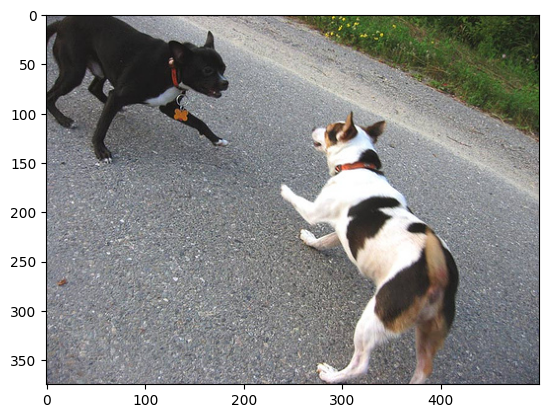

In [40]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
--------------------Predicted--------------------
startseq girl in purple coat sitting in front of painted rainbow endseq


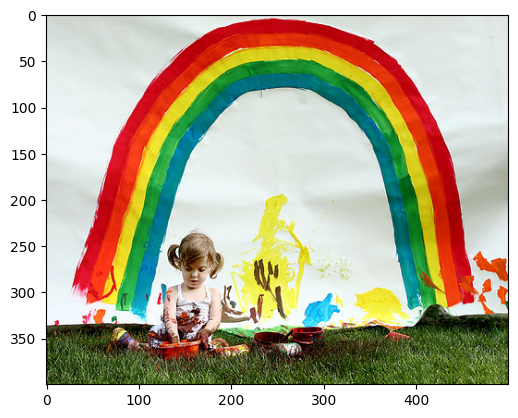

In [41]:
generate_caption("1002674143_1b742ab4b8.jpg")

---------------------Actual---------------------
startseq hiker in tent on mountain endseq
startseq hiker pokes his head out of tent high in the mountains endseq
startseq man sits in his tent on mountain endseq
startseq person sticks their head out of tent at the top of mountain endseq
startseq someone is peaking out of dome tent pitched near snowy mountain endseq
--------------------Predicted--------------------
startseq snowy mountain climber endseq


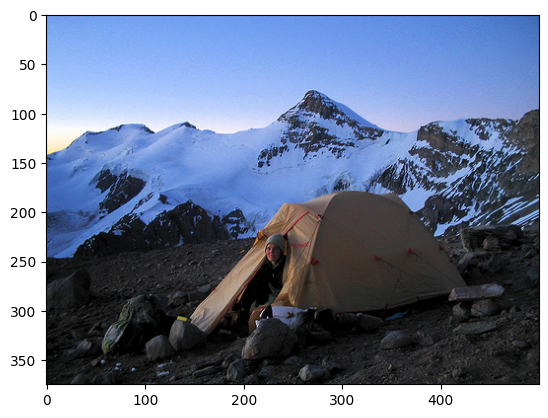

In [42]:
generate_caption("57422853_b5f6366081.jpg")

---------------------Actual---------------------
startseq black and white dog is herding group of sheep on dusty road endseq
startseq black and white dog is watching over flock of white sheep endseq
startseq dog in near herd of sheep endseq
startseq sheepdog is rounding up herd of sheep endseq
startseq wolf-like dog herds pack of white sheep on dusty farm endseq
--------------------Predicted--------------------
startseq two dogs are playing in the grass endseq


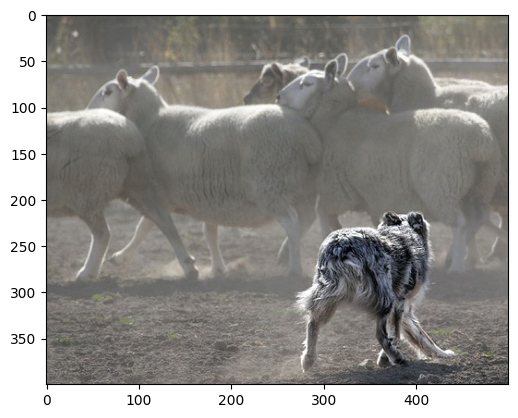

In [43]:
generate_caption("843616798_5ab0ecb525.jpg")

---------------------Actual---------------------
startseq group of young men clowning around while enjoying beverage endseq
startseq five men pose awkwardly on steps endseq
startseq five young men pose on the steps endseq
startseq four boys posing while one boy sets his drink down endseq
startseq group of young men posing and holding cans endseq
--------------------Predicted--------------------
startseq woman and woman sitting on bench endseq


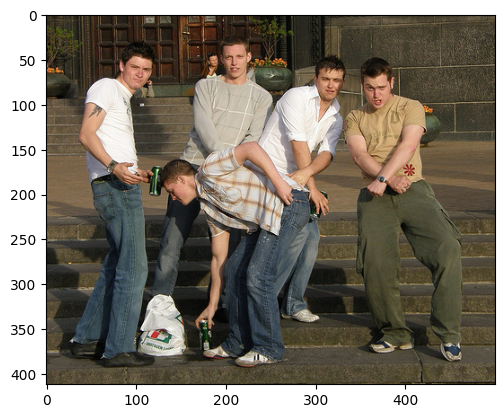

In [44]:
generate_caption("498444334_a680d318a1.jpg")

---------------------Actual---------------------
startseq girl at wedding holding some orange flowers endseq
startseq girl holds bouquet of flowers endseq
startseq little girl at wedding holds bouquet of orange flowers endseq
startseq little girl holds orange lilies while others celebrate an occasion in garden setting endseq
startseq young girl in orange dress holding orange flowers endseq
--------------------Predicted--------------------
startseq two girls in bright colored clothing are walking on the grass endseq


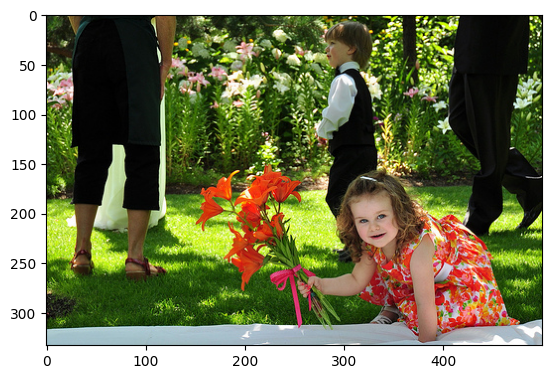

In [45]:
generate_caption("3760400645_3ba51d27f9.jpg")